In [1]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files

# VEST Florida Validation

In [2]:
vest_fl_16 = gp.read_file("./raw-from-source/VEST/fl_2016/fl_2016.shp")

## Documentation

### Races

G16PRERTru - Donald J. Trump (Republican Party)  
G16PREDCli - Hillary Clinton (Democratic Party)  
G16PRELJoh - Gary Johnson (Libertarian Party)  
G16PRECCas - Darrell L. Castle (Constitution Party)  
G16PREGSte - Jill Stein (Green Party)  
G16PREIDeL - Roque De La Fuente (Reform Party)  
G16PREOth - Write-in Votes  

G16USSRRub - Marco Rubio (Republican Party)  
G16USSDMur - Patrick Murphy (Democratic Party)  
G16USSLSta - Paul Stanton (Libertarian Party)  
G16USSOth - Independent and Write-in Votes  

### Election Source

Election results from Florida Division of Elections (http://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)  

### Precinct Source

The starting point was the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  

Hillsborough, Lake, Miami-Dade, Orange, Palm Beach, and Pinellas Counties were updated directly with shapefiles downloaded from county Supervisor of Elections websites.  

Brevard, Marion, and Putnam Counties were updated with KML files from the respective county Supervisor of Elections websites, from their election result map pages.  

Columbia, DeSoto, Leon, Polk, and Osceola Counties updates received from Supervisor of Elections websites through personal contact.  

Highlands, Santa Rosa, Sarasota, and Volusia Counties had some precinct mergers, which were determined based on visual inspection of PDF precinct maps from the county websites.  

Charlotte, Hendry, Holmes, Jackson, Jefferson, Levy, Madison, and Walton Counties are from VTDs released by the Census Bureau's Redistricting Data Program.  

Hernando 99, Collier 450, and Palm Beach 8001/8002 are UOCAVA precincts with no real geography and votes were not redistributed.  

Precinct names were adjusted to align with the formatting used in the voter registration file (e.g., some precincts have leading spaces).  

## Load Election Results

In [3]:
all_files = os.listdir("./raw-from-source/Election_Results/precinctlevelelectionresults2016gen")

In [4]:
#Check that all files have the same number of columns
#for i in all_files:
    #ref = "./raw-from-source/Election_Results/precinctlevelelectionresults2016gen/"
    #file_ref = ref+i
    #print(i)
    #file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None, error_bad_lines=False)
    #print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

In [73]:
#Create a dataframe with the txt files
li = []
for i in all_files:
    ref = "./raw-from-source/Election_Results/precinctlevelelectionresults2016gen/"
    file_ref = ref+i
    file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None,error_bad_lines=False)
    li.append(file_prev)
frame = pd.concat(li, axis=0, ignore_index=True)

Skipping line 28: '	' expected after '"'
Skipping line 106: '	' expected after '"'
Skipping line 185: '	' expected after '"'
Skipping line 263: '	' expected after '"'
Skipping line 346: '	' expected after '"'
Skipping line 429: '	' expected after '"'
Skipping line 510: '	' expected after '"'
Skipping line 587: '	' expected after '"'
Skipping line 662: '	' expected after '"'
Skipping line 741: '	' expected after '"'
Skipping line 829: '	' expected after '"'
Skipping line 916: '	' expected after '"'
Skipping line 994: '	' expected after '"'
Skipping line 1076: '	' expected after '"'
Skipping line 70: '	' expected after '"'
Skipping line 173: '	' expected after '"'
Skipping line 330: '	' expected after '"'
Skipping line 431: '	' expected after '"'
Skipping line 518: '	' expected after '"'
Skipping line 617: '	' expected after '"'
Skipping line 708: '	' expected after '"'
Skipping line 814: '	' expected after '"'
Skipping line 916: '	' expected after '"'
Skipping line 1014: '	' expected af

Skipping line 26551: '	' expected after '"'
Skipping line 26639: '	' expected after '"'
Skipping line 26728: '	' expected after '"'
Skipping line 26773: '	' expected after '"'
Skipping line 26841: '	' expected after '"'
Skipping line 26917: '	' expected after '"'
Skipping line 26997: '	' expected after '"'
Skipping line 27091: '	' expected after '"'
Skipping line 27189: '	' expected after '"'
Skipping line 27290: '	' expected after '"'
Skipping line 27385: '	' expected after '"'
Skipping line 27486: '	' expected after '"'
Skipping line 27577: '	' expected after '"'
Skipping line 27666: '	' expected after '"'
Skipping line 27763: '	' expected after '"'
Skipping line 27860: '	' expected after '"'
Skipping line 27952: '	' expected after '"'
Skipping line 28045: '	' expected after '"'
Skipping line 28140: '	' expected after '"'
Skipping line 28241: '	' expected after '"'
Skipping line 28338: '	' expected after '"'
Skipping line 28425: '	' expected after '"'
Skipping line 28523: '	' expecte

Skipping line 51668: '	' expected after '"'
Skipping line 51765: '	' expected after '"'
Skipping line 51862: '	' expected after '"'
Skipping line 51956: '	' expected after '"'
Skipping line 52056: '	' expected after '"'
Skipping line 52144: '	' expected after '"'
Skipping line 52234: '	' expected after '"'
Skipping line 52325: '	' expected after '"'
Skipping line 52419: '	' expected after '"'
Skipping line 52514: '	' expected after '"'
Skipping line 52611: '	' expected after '"'
Skipping line 52708: '	' expected after '"'
Skipping line 52805: '	' expected after '"'
Skipping line 52899: '	' expected after '"'
Skipping line 52989: '	' expected after '"'
Skipping line 53063: '	' expected after '"'
Skipping line 53152: '	' expected after '"'
Skipping line 53247: '	' expected after '"'
Skipping line 53339: '	' expected after '"'
Skipping line 53415: '	' expected after '"'
Skipping line 53490: '	' expected after '"'
Skipping line 53592: '	' expected after '"'
Skipping line 53682: '	' expecte

In the above, two counties have errors on certain lines, but these are not for either President or Senate races.

## Clean Election Results

In [74]:
#Clean up column names
frame.columns = frame.iloc[395275]
frame.drop([395275],inplace=True)

#Reset index
frame.reset_index(inplace=True,drop=True)

#Name
frame["ContestName"]=frame["ContestName"].str.upper()

early_frame = frame.copy()

In [75]:
#Filter down to the relevant races

office_List = ['PRESIDENT OF THE UNITED STATES','UNITED STATES SENATOR','President of the United States','United States Senator']
bad_name_List = ['OverVotes','UnderVotes','Times Blank Voted','Times Over Voted']
filtered_frame=frame[(frame["ContestName"].isin(office_List)) & ~(frame["CanName"].isin(bad_name_List))]
cand_name_dict = {"Trump / Pence":"Donald J. Trump","Clinton / Kaine":"Hillary R. Clinton",
                 "Johnson / Weld":"Gary Johnson","Stein / Baraka":"Jill Stein",
                 "Write-in":"WriteIn","De La Fuente / Steinberg":"Roque De La Fuente",
                 "Castle / Bradley":"Darrell L. Castle",'WriteInVotes':'WriteIn','WriteinVotes':'WriteIn'}

#Clean the candidate names
filtered_frame["CanName"]=filtered_frame["CanName"].map(cand_name_dict).fillna(filtered_frame["CanName"])

<ipython-input-75-2124c89506df>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["CanName"]=filtered_frame["CanName"].map(cand_name_dict).fillna(filtered_frame["CanName"])


In [76]:
#Make the precinct column at least 4 digits
filtered_frame["modified_pre"]=filtered_frame["Precinct"].astype(str).str.zfill(5) 

#Make a column with the 3 letter county code and the precincts
filtered_frame["Pct_std"]=filtered_frame["CountyCode"]+filtered_frame["modified_pre"]

<ipython-input-76-e45b03ffcd91>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["modified_pre"]=filtered_frame["Precinct"].astype(str).str.zfill(5)
<ipython-input-76-e45b03ffcd91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Pct_std"]=filtered_frame["CountyCode"]+filtered_frame["modified_pre"]


In [77]:
#Standardize the candidate names and create a column to pivot with
filtered_frame["CanName"]= filtered_frame["CanName"].str.upper()
filtered_frame["ContestName"] = filtered_frame["ContestName"].str.upper()
filtered_frame["pivot_col"]=filtered_frame["CanName"]+filtered_frame["ContestName"]

<ipython-input-77-42919fb37859>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["CanName"]= filtered_frame["CanName"].str.upper()
<ipython-input-77-42919fb37859>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["ContestName"] = filtered_frame["ContestName"].str.upper()
<ipython-input-77-42919fb37859>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [78]:
pd.options.display.max_rows = 999


dup_list = ["PAL05003","PAL05007","PAL02083","PAL02097","PAL05119","PAL"]
display(filtered_frame[filtered_frame["Pct_std"].isin(dup_list)])

395275,CountyCode,CountyName,ElectionNumber,ElectionDate,ElectionName,Precinct,PollingLocation,ReVoters,RegDem,RegRep,...,DistrictName,ContestID,CanName,CanParty,VoterID,CanAcct,CanVotes,modified_pre,Pct_std,pivot_col
414051,PAL,Palm Beach,10282,11/08/2016,2016 General Election,2083,"2082, 2083, 2085, 2087, 2090, 2092, 2094",41,0,0,...,,100000,DONALD J. TRUMP,REP,0,65072,18,02083,PAL02083,DONALD J. TRUMPPRESIDENT OF THE UNITED STATES
414052,PAL,Palm Beach,10282,11/08/2016,2016 General Election,2083,2083,41,0,0,...,,100000,DONALD J. TRUMP,REP,0,65072,18,02083,PAL02083,DONALD J. TRUMPPRESIDENT OF THE UNITED STATES
414053,PAL,Palm Beach,10282,11/08/2016,2016 General Election,2083,"2082, 2083, 2085, 2087, 2090, 2092, 2094",41,0,0,...,,100000,HILLARY R. CLINTON,DEM,0,65058,8,02083,PAL02083,HILLARY R. CLINTONPRESIDENT OF THE UNITED STATES
414054,PAL,Palm Beach,10282,11/08/2016,2016 General Election,2083,2083,41,0,0,...,,100000,HILLARY R. CLINTON,DEM,0,65058,8,02083,PAL02083,HILLARY R. CLINTONPRESIDENT OF THE UNITED STATES
414055,PAL,Palm Beach,10282,11/08/2016,2016 General Election,2083,"2082, 2083, 2085, 2087, 2090, 2092, 2094",41,0,0,...,,100000,GARY JOHNSON,LPF,0,69370,1,02083,PAL02083,GARY JOHNSONPRESIDENT OF THE UNITED STATES
414056,PAL,Palm Beach,10282,11/08/2016,2016 General Election,2083,2083,41,0,0,...,,100000,GARY JOHNSON,LPF,0,69370,1,02083,PAL02083,GARY JOHNSONPRESIDENT OF THE UNITED STATES
414057,PAL,Palm Beach,10282,11/08/2016,2016 General Election,2083,"2082, 2083, 2085, 2087, 2090, 2092, 2094",41,0,0,...,,100000,JILL STEIN,GRE,0,69377,2,02083,PAL02083,JILL STEINPRESIDENT OF THE UNITED STATES
414058,PAL,Palm Beach,10282,11/08/2016,2016 General Election,2083,2083,41,0,0,...,,100000,JILL STEIN,GRE,0,69377,2,02083,PAL02083,JILL STEINPRESIDENT OF THE UNITED STATES
414061,PAL,Palm Beach,10282,11/08/2016,2016 General Election,2083,"2082, 2083, 2085, 2087, 2090, 2092, 2094",41,0,0,...,,120000,MARCO RUBIO,REP,109340956,65070,20,02083,PAL02083,MARCO RUBIOUNITED STATES SENATOR
414062,PAL,Palm Beach,10282,11/08/2016,2016 General Election,2083,2083,41,0,0,...,,120000,MARCO RUBIO,REP,109340956,65070,20,02083,PAL02083,MARCO RUBIOUNITED STATES SENATOR


In [79]:
#Pivot the election results
pivoted_2016 = pd.pivot_table(filtered_frame, values=["CanVotes"], index=["Pct_std"],columns=["pivot_col"],aggfunc=sum)
pivoted_2016.columns = pivoted_2016.columns.droplevel(0)
pivoted_2016.reset_index(drop=False,inplace=True)
pivoted_2016 = pivoted_2016.fillna(0)

In [80]:
#print(pivoted_2016.head())
for i in pivoted_2016.columns:
    if i !="Pct_std":
        print(i)
        print(sum(pivoted_2016[i]))

BASIL E. DALACKUNITED STATES SENATOR
22246.0
BRUCE NATHANUNITED STATES SENATOR
52481.0
DARRELL L. CASTLEPRESIDENT OF THE UNITED STATES
16488.0
DONALD J. TRUMPPRESIDENT OF THE UNITED STATES
4620979.0
GARY JOHNSONPRESIDENT OF THE UNITED STATES
207158.0
HILLARY R. CLINTONPRESIDENT OF THE UNITED STATES
4508731.0
JILL STEINPRESIDENT OF THE UNITED STATES
64433.0
MARCO RUBIOUNITED STATES SENATOR
4838542.0
PATRICK MURPHYUNITED STATES SENATOR
4125533.0
PAUL STANTONUNITED STATES SENATOR
196999.0
ROQUE DE LA FUENTEPRESIDENT OF THE UNITED STATES
9109.0
STEVEN MACHATUNITED STATES SENATOR
26927.0
TONY KHOURYUNITED STATES SENATOR
45838.0
WRITEINPRESIDENT OF THE UNITED STATES
77570.0
WRITEINUNITED STATES SENATOR
13516.0


In [81]:
pivoted_2016.columns=(['countypct',"sen_wi_1","sen_wi_2","G16PRECCas",
                       "G16PRERTru","G16PRELJon","G16PREDCli","G16PREGSte",
                       "G16USSRRub","G16USSDMur","G16USSLSta","G16PREIDeL",
                       "sen_wi_3","sen_wi_4","G16PREoth","sen_wi_5"])

#Deal with the write-in votes
pivoted_2016["G16USSOth"]=pivoted_2016["sen_wi_1"]+pivoted_2016["sen_wi_2"]+pivoted_2016["sen_wi_3"]+pivoted_2016["sen_wi_4"]+pivoted_2016["sen_wi_5"]
pivoted_2016.drop(["sen_wi_1","sen_wi_2","sen_wi_3","sen_wi_4","sen_wi_5"], axis=1,inplace=True)

#Deal with N/A values
pivoted_2016 = pivoted_2016.fillna(0)

#Recreate the county column using the pivoting column
pivoted_2016["county"]=pivoted_2016["countypct"].str[0:3]

In [82]:
print(pivoted_2016.columns)
print(vest_fl_16.columns)

Index(['countypct', 'G16PRECCas', 'G16PRERTru', 'G16PRELJon', 'G16PREDCli',
       'G16PREGSte', 'G16USSRRub', 'G16USSDMur', 'G16USSLSta', 'G16PREIDeL',
       'G16PREoth', 'G16USSOth', 'county'],
      dtype='object')
Index(['pct', 'county', 'countypct', 'G16PRERTru', 'G16PREDCli', 'G16PRELJon',
       'G16PRECCas', 'G16PREGSte', 'G16PREIDeL', 'G16PREoth', 'G16USSRRub',
       'G16USSDMur', 'G16USSLSta', 'G16USSOth', 'geometry'],
      dtype='object')


In [83]:
print(sum(pivoted_2016['G16USSOth']))
print(sum(vest_fl_16['G16USSOth']))

161008.0
168360


### Check Election Results Totals

In [84]:
print(pivoted_2016.groupby(["county"]).sum())
print(vest_fl_16.groupby(["county"]).sum())


        G16PRECCas  G16PRERTru  G16PRELJon  G16PREDCli  G16PREGSte  \
county                                                               
ALA          262.0     46834.0      4059.0     75820.0      1507.0   
BAK           23.0     10294.0       169.0      2112.0        30.0   
BAY          179.0     62194.0      2652.0     21797.0       562.0   
BRA           33.0      8913.0       177.0      2924.0        47.0   
BRE          744.0    181848.0      9451.0    119679.0      2708.0   
BRO          907.0    260951.0     11078.0    553320.0      5094.0   
CAL           25.0      4655.0       124.0      1241.0        25.0   
CHA          127.0     60218.0      1946.0     33445.0       567.0   
CIT          182.0     54456.0      1724.0     22789.0       480.0   
CLA          223.0     74963.0      2806.0     27822.0       571.0   
CLL          172.0    105423.0      3263.0     61085.0       747.0   
CLM           44.0     20368.0       523.0      7601.0       150.0   
DAD         1273.0  

In [85]:
col_list = ['G16PRECCas', 'G16PRERTru', 'G16PRELJon', 'G16PREDCli',
       'G16PREGSte', 'G16USSRRub', 'G16USSDMur', 'G16USSLSta', 'G16PREIDeL',
       'G16PREoth', 'G16USSOth']

for i in col_list:
    diff = pivoted_2016.groupby(["county"]).sum()[i]-vest_fl_16.groupby(["county"]).sum()[i]
    print(i)
    print(diff[diff != 0])
    print("")

G16PRECCas
county
PAL    16.0
Name: G16PRECCas, dtype: float64

G16PRERTru
county
CLL      50.0
FLA       4.0
LAK       9.0
OSC       7.0
PAL    3562.0
Name: G16PRERTru, dtype: float64

G16PRELJon
county
CLL      3.0
PAL    148.0
Name: G16PRELJon, dtype: float64

G16PREDCli
county
CLL      72.0
FLA       9.0
LAK       5.0
OSC      52.0
PAL    4435.0
Name: G16PREDCli, dtype: float64

G16PREGSte
county
CLL     2.0
OSC     1.0
PAL    45.0
Name: G16PREGSte, dtype: float64

G16USSRRub
county
CLL      58.0
FLA       6.0
PAL    3879.0
Name: G16USSRRub, dtype: float64

G16USSDMur
county
CLL      58.0
FLA       7.0
PAL    4055.0
Name: G16USSDMur, dtype: float64

G16USSLSta
county
CLL     4.0
PAL    68.0
Name: G16USSLSta, dtype: float64

G16PREIDeL
county
PAL    2.0
Name: G16PREIDeL, dtype: float64

G16PREoth
county
CLL     1.0
PAL    42.0
Name: G16PREoth, dtype: float64

G16USSOth
county
CLL       2.0
PAL      87.0
SEM   -7441.0
Name: G16USSOth, dtype: float64



### 5 counties have election differences (excluding USSOth)

#### PAL

In [86]:
for i in col_list:
    print(i +": "+ str(sum(pivoted_2016[pivoted_2016["county"]=="PAL"][i])-sum(vest_fl_16[vest_fl_16["county"]=="PAL"][i])))

G16PRECCas: 16.0
G16PRERTru: 3562.0
G16PRELJon: 148.0
G16PREDCli: 4435.0
G16PREGSte: 45.0
G16USSRRub: 3879.0
G16USSDMur: 4055.0
G16USSLSta: 68.0
G16PREIDeL: 2.0
G16PREoth: 42.0
G16USSOth: 87.0


In [87]:
#print(pivoted_2016[pivoted_2016["countypct"].str[0:3]=="PAL"]["countypct"].value_counts())

dup_list = ["PAL01173","PAL01189","PAL01247","PAL02081","PAL02083","PAL02097","PAL02116",
            "PAL02126","PAL04129","PAL05003","PAL05007","PAL05018","PAL05055",
           "PAL05112","PAL05113","PAL05115","PAL05117","PAL05119","PAL06207","PAL07149"]
no_shape_list = ["PAL08001","PAL08002"]

#print(pivoted_2016[pivoted_2016["countypct"].isin(dup_list)])
#print(pivoted_2016[pivoted_2016["countypct"].isin(no_shape_list)])


for i in col_list:
    val = sum(pivoted_2016[pivoted_2016["countypct"].isin(dup_list)][i])/2 + sum(pivoted_2016[pivoted_2016["countypct"].isin(no_shape_list)][i])
    print(i+": "+str(val))

G16PRECCas: 16.0
G16PRERTru: 3562.0
G16PRELJon: 148.0
G16PREDCli: 4435.0
G16PREGSte: 45.0
G16USSRRub: 3879.0
G16USSDMur: 4055.0
G16USSLSta: 68.0
G16PREIDeL: 2.0
G16PREoth: 42.0
G16USSOth: 87.0


In [88]:
for i in dup_list:
    for j in col_list:
        #print(pivoted_2016.loc[pivoted_2016["countypct"]==i,[j]])
        pivoted_2016.loc[pivoted_2016["countypct"]==i,[j]] = pivoted_2016.loc[pivoted_2016["countypct"]==i,[j]]/2
        #print(pivoted_2016.loc[pivoted_2016["countypct"]==i,[j]])

In [89]:
#### CLL
for i in col_list:
    print(i +": "+ str(sum(pivoted_2016[pivoted_2016["county"]=="CLL"][i])-sum(vest_fl_16[vest_fl_16["county"]=="CLL"][i])))
#Precinct 450
print(pivoted_2016[pivoted_2016["countypct"]=="CLL00450"])

G16PRECCas: 0.0
G16PRERTru: 50.0
G16PRELJon: 3.0
G16PREDCli: 72.0
G16PREGSte: 2.0
G16USSRRub: 58.0
G16USSDMur: 58.0
G16USSLSta: 4.0
G16PREIDeL: 0.0
G16PREoth: 1.0
G16USSOth: 2.0
     countypct  G16PRECCas  G16PRERTru  G16PRELJon  G16PREDCli  G16PREGSte  \
1077  CLL00450         0.0        50.0         3.0        72.0         2.0   

      G16USSRRub  G16USSDMur  G16USSLSta  G16PREIDeL  G16PREoth  G16USSOth  \
1077        58.0        58.0         4.0         0.0        1.0        2.0   

     county  
1077    CLL  


In [90]:
#### FLA
for i in col_list:
    print(i +": "+ str(sum(pivoted_2016[pivoted_2016["county"]=="FLA"][i])-sum(vest_fl_16[vest_fl_16["county"]=="FLA"][i])))
#Precinct 999
print(pivoted_2016[pivoted_2016["countypct"]=="FLA00999"])

G16PRECCas: 0.0
G16PRERTru: 4.0
G16PRELJon: 0.0
G16PREDCli: 9.0
G16PREGSte: 0.0
G16USSRRub: 6.0
G16USSDMur: 7.0
G16USSLSta: 0.0
G16PREIDeL: 0.0
G16PREoth: 0.0
G16USSOth: 0.0
     countypct  G16PRECCas  G16PRERTru  G16PRELJon  G16PREDCli  G16PREGSte  \
2224  FLA00999         0.0         4.0         0.0         9.0         0.0   

      G16USSRRub  G16USSDMur  G16USSLSta  G16PREIDeL  G16PREoth  G16USSOth  \
2224         6.0         7.0         0.0         0.0        0.0        0.0   

     county  
2224    FLA  


In [91]:
#### LAK
for i in col_list:
    print(i +": "+ str(sum(pivoted_2016[pivoted_2016["county"]=="LAK"][i])-sum(vest_fl_16[vest_fl_16["county"]=="LAK"][i])))
#Precinct 108
print(pivoted_2016[pivoted_2016["countypct"]=="LAK00108"])

G16PRECCas: 0.0
G16PRERTru: 9.0
G16PRELJon: 0.0
G16PREDCli: 5.0
G16PREGSte: 0.0
G16USSRRub: 0.0
G16USSDMur: 0.0
G16USSLSta: 0.0
G16PREIDeL: 0.0
G16PREoth: 0.0
G16USSOth: 0.0
     countypct  G16PRECCas  G16PRERTru  G16PRELJon  G16PREDCli  G16PREGSte  \
2909  LAK00108         0.0         9.0         0.0         5.0         0.0   

      G16USSRRub  G16USSDMur  G16USSLSta  G16PREIDeL  G16PREoth  G16USSOth  \
2909         0.0         0.0         0.0         0.0        0.0        0.0   

     county  
2909    LAK  


In [92]:
#### OSC
for i in col_list:
    print(i +": "+ str(sum(pivoted_2016[pivoted_2016["county"]=="OSC"][i])-sum(vest_fl_16[vest_fl_16["county"]=="OSC"][i])))
#OSC - Precinct 999
print(pivoted_2016[pivoted_2016["countypct"]=="OSC00999"])

G16PRECCas: 0.0
G16PRERTru: 7.0
G16PRELJon: 0.0
G16PREDCli: 52.0
G16PREGSte: 1.0
G16USSRRub: 0.0
G16USSDMur: 0.0
G16USSLSta: 0.0
G16PREIDeL: 0.0
G16PREoth: 0.0
G16USSOth: 0.0
     countypct  G16PRECCas  G16PRERTru  G16PRELJon  G16PREDCli  G16PREGSte  \
3892  OSC00999         0.0         7.0         0.0        52.0         1.0   

      G16USSRRub  G16USSDMur  G16USSLSta  G16PREIDeL  G16PREoth  G16USSOth  \
3892         0.0         0.0         0.0         0.0        0.0        0.0   

     county  
3892    OSC  


### Check totals after deleting double counts

In [93]:
not_included_list = ["PAL08001","PAL08002","CLL00450","FLA00999","LAK00108","OSC00999"]
not_included_df = pivoted_2016[pivoted_2016["countypct"].isin(not_included_list)]

In [94]:
for i in col_list:
    print("The difference between source and vest is for "+i+"is "+ str(sum(pivoted_2016[i])-sum(vest_fl_16[i])))
    print("The totals of the not included precincts for " +i+" are " + str(sum(not_included_df[i])))
for i in col_list:
    print(i+": "+ str(sum(pivoted_2016[i])))
    
for i in col_list:
    print(i+": "+ str(sum(not_included_df[i])))

The difference between source and vest is for G16PRECCasis 2.0
The totals of the not included precincts for G16PRECCas are 2.0
The difference between source and vest is for G16PRERTruis 129.0
The totals of the not included precincts for G16PRERTru are 129.0
The difference between source and vest is for G16PRELJonis 7.0
The totals of the not included precincts for G16PRELJon are 7.0
The difference between source and vest is for G16PREDCliis 246.0
The totals of the not included precincts for G16PREDCli are 246.0
The difference between source and vest is for G16PREGSteis 4.0
The totals of the not included precincts for G16PREGSte are 4.0
The difference between source and vest is for G16USSRRubis 139.0
The totals of the not included precincts for G16USSRRub are 139.0
The difference between source and vest is for G16USSDMuris 156.0
The totals of the not included precincts for G16USSDMur are 156.0
The difference between source and vest is for G16USSLStais 5.0
The totals of the not included p

### Deal with USSOther differences

In [95]:
diff = pivoted_2016.groupby(["county"]).sum()['G16USSOth']-vest_fl_16.groupby(["county"]).sum()['G16USSOth']
print(diff[diff != 0])


county
CLL       2.0
PAL       1.0
SEM   -7441.0
Name: G16USSOth, dtype: float64


In [96]:
#The CLL and PAL differences are attributable to CLL00450, PAL08001, and PAL08002

print(pivoted_2016[pivoted_2016["countypct"]=="CLL00450"]["G16USSOth"])
print(pivoted_2016[pivoted_2016["countypct"]=="PAL08001"]["G16USSOth"])
print(pivoted_2016[pivoted_2016["countypct"]=="PAL08002"]["G16USSOth"])

1077    2.0
Name: G16USSOth, dtype: float64
4676    1.0
Name: G16USSOth, dtype: float64
4677    0.0
Name: G16USSOth, dtype: float64


In [97]:
#These votes are explainable b/c it seems as if VEST included blank voted and over voted in the total
weird_votes_list = ["Times Blank Voted","Times Over Voted"]
print(sum(early_frame[(early_frame["CountyCode"]=="SEM") &(early_frame["ContestName"]=="UNITED STATES SENATOR") &(early_frame["CanName"].isin(weird_votes_list))]["CanVotes"]))

7441


### Create an election results merge column

In [98]:
#Merge column is the three letter county, plus a 5-character precinct name
vest_fl_16["countypct"] = vest_fl_16["county"]+vest_fl_16["pct"].str.zfill(5)

In [99]:
#Update merge column to match VEST's file
source_precinct_election_changes_dict = {"WAS00014":"WAS00017","WAS00016":"WAS00019","HAR00017":"HAR00009","HAR00015":"HAR00007",
    "PUT00031":"PUT00035","HAR00018":"HAR00010"}

pivoted_2016["countypct"]=pivoted_2016["countypct"].map(source_precinct_election_changes_dict).fillna(pivoted_2016["countypct"])

In [103]:
#Deal with 0 votes precincts
vest_empty = vest_fl_16[(vest_fl_16['G16PRERTru']==0) & (vest_fl_16['G16PREDCli']==0) &
              (vest_fl_16['G16PRELJon']==0) & (vest_fl_16['G16PRECCas']==0) &
              (vest_fl_16['G16PREGSte']==0) & (vest_fl_16['G16PREIDeL']==0) &
              (vest_fl_16['G16PREoth']==0) & (vest_fl_16['G16USSRRub']==0) &
              (vest_fl_16['G16USSDMur']==0) & (vest_fl_16['G16USSLSta']==0) &
              (vest_fl_16['G16USSOth']==0)]

vest_empty = vest_empty[~vest_empty["countypct"].isin(pivoted_2016["countypct"])]

In [104]:




#Create the zero vote precincts in the MEDSL file
new_precincts = pd.DataFrame(columns=pivoted_2016.columns)
new_precincts["countypct"]=vest_empty["countypct"]
new_precincts["county"]=vest_empty["countypct"].str[0:3]

col_list = ['G16PRECCas', 'G16PRERTru', 'G16PRELJon', 'G16PREDCli',
       'G16PREGSte', 'G16USSRRub', 'G16USSDMur', 'G16USSLSta', 'G16PREIDeL',
       'G16PREoth', 'G16USSOth']

#Set the 0 vote values for these precincts
for i in col_list:
    new_precincts[i]=0

#Add these new precincts
pivoted_2016= pivoted_2016.append(new_precincts)
pivoted_2016.reset_index(drop=True,inplace=True)

#### Check election results (w/o shapefile data) against VEST file

In [105]:
check_election = pd.merge(vest_fl_16,pivoted_2016,how="outer",on="countypct",indicator=True)

print(check_election["_merge"].value_counts())
#check_election[check_election["_merge"]=="left_only"].to_csv("./vest_election.csv")
#check_election[check_election["_merge"]=="right_only"].to_csv("./source_election.csv")


print(check_election[check_election["_merge"]=="left_only"]["countypct"])
print(check_election[check_election["_merge"]=="right_only"]["countypct"])

#PAL08001, PAL08002, OSC00999, #LAK00108, #FLA00999, #CLL00450


#PAL08001, PAL08002, OSC00999, #LAK00108, #FLA00999, #CLL00450


#17 from the VEST_FL file, didn't match:
# -> 10 of these correspond to 5 in source file

#23 from the pivoted file
# -> 6 were identified in the above 
# -> 5 are combined versions of 10 unjoined precincts


both          5950
right_only      23
left_only       17
Name: _merge, dtype: int64
908     UNI0001A
909     UNI0001B
910     UNI0002A
911     UNI0002B
912     UNI0003A
913     UNI0003B
915     UNI0004A
917     UNI0004C
918     UNI0005A
920     UNI0005C
1075    PUT00034
1084    PUT00038
1095    PUT00039
5090    HAR00003
5091    HAR00004
5093    HAR00006
5738    WAS00018
Name: countypct, dtype: object
5967      CLL00450
5968      FLA00999
5969      HAR00016
5970      HAR00021
5971      HAR00022
5972      LAK00108
5973      OSC00999
5974      PAL08001
5975      PAL08002
5976      PUT00013
5977      PUT00017
5978      PUT00029
5979      SAR00430
5980      SAR00502
5981    UNI1A & 1B
5982    UNI2A & 2B
5983    UNI3A & 3B
5984    UNI4A & 4C
5985    UNI5A & 5C
5986      WAL00431
5987      WAL00441
5988      WAL00541
5989      WAS00013
Name: countypct, dtype: object


In [106]:
diff_list = ['HAR00005', 'HAR00008', 'HAR00011', 'HAR00012', 'PAL01173', 'PAL01189', 'PAL01247', 'PAL02081', 'PAL02083', 'PAL02097', 'PAL02116', 'PAL02126', 'PAL04129', 'PAL05003', 'PAL05007', 'PAL05018', 'PAL05055', 'PAL05112', 'PAL05113', 'PAL05115', 'PAL05117', 'PAL05119', 'PAL06207', 'PAL07149', 'PUT00014', 'PUT00015', 'PUT00016', 'PUT00018', 'PUT00019', 'PUT00020', 'PUT00021', 'PUT00022', 'PUT00023', 'PUT00024', 'PUT00025', 'PUT00026', 'PUT00027', 'PUT00028', 'PUT00030', 'PUT00032', 'PUT00033', 'PUT00036', 'PUT00037', 'SAR00429', 'SAR00501', 'WAL00430', 'WAL00440', 'WAL00540', 'WAS00015']

In [107]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                #print(df.iloc[j]['countypct'])
                #print(i)
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['countypct'])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    print("New max diff is: ", str(max_diff))
                    print(df.iloc[j]['countypct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['countypct'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")
    diff_list.sort()
    print(diff_list)

#### Check excluding the US Senate "other" results

In [108]:
col_list = ["G16PRERTru","G16PREDCli","G16PRELJon","G16PRECCas","G16PREGSte","G16PREIDeL","G16PREoth","G16USSRRub","G16USSDMur","G16USSLSta"]


validater_row(check_election[check_election["_merge"]=="both"],col_list)

New max diff is:  683.0
SAR00429
New max diff is:  729.0
SAR00429
New max diff is:  1603.0
SAR00501
New max diff is:  1622.0
SAR00501
There are  5950  total rows
29  of these rows have election result differences
5921  of these rows are the same

The max difference between any one shared column in a row is:  1622.0
The average difference is:  124.29885057471265
There are  139 precinct results with a difference greater than 5
['HAR00005', 'HAR00008', 'HAR00011', 'HAR00012', 'PUT00014', 'PUT00015', 'PUT00016', 'PUT00018', 'PUT00019', 'PUT00020', 'PUT00021', 'PUT00022', 'PUT00023', 'PUT00024', 'PUT00025', 'PUT00026', 'PUT00027', 'PUT00028', 'PUT00030', 'PUT00032', 'PUT00033', 'PUT00036', 'PUT00037', 'SAR00429', 'SAR00501', 'WAL00430', 'WAL00440', 'WAL00540', 'WAS00015']


## Precinct Shapefiles

### VEST Shapefile Documentation

The starting point was the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  

Hillsborough, Lake, Miami-Dade, Orange, Palm Beach, and Pinellas Counties were updated directly with shapefiles downloaded from county Supervisor of Elections websites.  

Brevard, Marion, and Putnam Counties were updated with KML files from the respective county Supervisor of Elections websites, from their election result map pages.  

Columbia, DeSoto, Leon, Polk, and Osceola Counties updates received from Supervisor of Elections websites through personal contact.  

Highlands, Santa Rosa, Sarasota, and Volusia Counties had some precinct mergers, which were determined based on visual inspection of PDF precinct maps from the county websites.  

Charlotte, Hendry, Holmes, Jackson, Jefferson, Levy, Madison, and Walton Counties are from VTDs released by the Census Bureau's Redistricting Data Program.  

Hernando 99, Collier 450, and Palm Beach 8001/8002 are UOCAVA precincts with no real geography and votes were not redistributed.  

Precinct names were adjusted to align with the formatting used in the voter registration file (e.g., some precincts have leading spaces).  

### Validation Strategy

VEST's steps for creating the Florida shapefile are very time-consuming and complicated. Since, we recently received Florida precinct shapefile data through a public records request, we decided to use this to verify the VEST file. In general, for every county we looked for the shapefile on record that was closest to the 2016 election, with a preference for earlier shapefiles. If a county did not have a shapefile on record, we used a block-equivalency file.

#The below had shapefiles, but they were not able to load:
DAD,HIG,LAK,LEE,PAL,PIN,SUM

#Multiple files for BAY, CLL, SUM, SUW, VOL

### Counties with precincts built using a block-equivalency file

#### Load precinct-block files and filter down to relevant columns

In [110]:
GAD_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/GAD/deleted_columns_PctBlock.csv",error_bad_lines=False)
#print(GAD_pct.head())

GIL_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/GIL/GIL20121106v6_PctBlock.txt",sep="\t", header=None)
GIL_pct.reset_index(inplace=True,drop=True)
GIL_pct = GIL_pct[[0,1,2]]
GIL_pct.columns = ['County','Precinct','Block']
#print(GIL_pct.head())

HAM_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HAM/HAM20140707_PctBlocka8ac771f-a98a-4718-bb62-f6dceab1369c.txt",sep="\t", header=None)
HAM_pct.reset_index(inplace=True,drop=True)
HAM_pct = HAM_pct[[0,1,2]]
HAM_pct.columns = ['County','Precinct','Block']
#print(HAM_pct.head())

JAC_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/JAC/cleaned_PctBlock.csv")
JAC_pct.columns = ['County','Precinct','Block']
JAC_pct["County"]="JAC"
#print(JAC_pct.head())

MAD_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/MAD/clean_PctBlock.csv")
MAD_pct.columns = ['County','Precinct','Block']
#print(MAD_pct.head())

MRN_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/MRN/MRN20160510PctBlocka03accb3-5931-4025-b0b3-ee84b1d78dce.txt",sep="\t", header=None)
MRN_pct.columns = ['County','Precinct','Block']
#print(MRN_pct.head())

TAY_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/TAY/TAY20120806_PctBlock0b8117f6-c1de-4b3f-8c25-1e78e2013cd7.txt",sep="\t", header=None)
TAY_pct.columns = ['County','Precinct','Block']
#print(TAY_pct.head())

DAD_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/DAD/DAD20150817_PctBlock8708ddd9-66e2-42f4-8249-d4aa549f0d92.txt",sep="\t")
DAD_pct=DAD_pct[["COUNTY CODE","PRECINCT NUMBER","CENSUS BLOCK"]]
DAD_pct.columns = ['County','Precinct','Block']
#print(DAD_pct.head())

HIG_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HIG/HIG20160801_PctBlock2b83ba25-1180-477a-b954-b31f1605fd92.txt",sep="\t")
HIG_pct=HIG_pct[["County Code","Precinct Number","Census Block"]]
HIG_pct.columns = ['County','Precinct','Block']
HIG_pct["County"]="HIG"
#print(HIG_pct.head())

LAK_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LAK/LAK20160420_PctBlock73e1ca5e-e9f7-48e1-b380-98b8401ad0f0.txt",sep="\t")
LAK_pct=LAK_pct[["County Code","Precinct Number","Census Block"]]
LAK_pct.columns = ['County','Precinct','Block']
LAK_pct["County"]="LAK"
#print(LAK_pct.head())

LEE_pct=pd.read_csv("/Users/peterhorton/Documents/Redistricting_Data_Hub/Coding/pdv/pdv-fl/vest-fl-2016/raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LEE/LEE20180813_PctBlock495f9750-05d2-4aa6-9b20-72a6a1fcef02.txt",sep="\t",header=None)
LEE_pct["County"]="LEE"
LEE_pct = LEE_pct[[1,2,'County']]
LEE_pct.columns = ['Precinct','Block','County']
LEE_pct = LEE_pct[['County','Precinct','Block']]
#print(LEE_pct.head())

PIN_pct=pd.read_csv("/Users/peterhorton/Documents/Redistricting_Data_Hub/Coding/pdv/pdv-fl/vest-fl-2016/raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/PIN/PIN20160503PCTBLOCK6239b364-d072-49e8-a23f-5162bcb5e8f7.TXT",sep=",")
PIN_pct["County"]="PIN"
PIN_pct.columns = ['Block','Precinct','County']
PIN_pct = PIN_pct[['County','Precinct','Block']]
#print(PIN_pct.head())

SUM_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SUM/SUM20150414_PctBlock5aacc620-010f-48b7-b03e-074bc85a3d2a.txt",sep='\t')
SUM_pct = SUM_pct[['County Code','PrecinctNu','CensusBloc']]
SUM_pct.columns = ['County','Precinct','Block']
SUM_pct["County"]="SUM"
#print(SUM_pct.head())

#### Create a list of these files

In [111]:
block_file_list = [GAD_pct,GIL_pct,HAM_pct,JAC_pct,MAD_pct,MRN_pct,TAY_pct,DAD_pct,HIG_pct,LAK_pct,LEE_pct,PIN_pct,SUM_pct]
block_counties = pd.concat(block_file_list)
#Create a unique ID
block_counties["unique_ID"]=block_counties["County"]+block_counties["Precinct"].astype(str)

#### Load Florida census block data

In [112]:
#Shapefiles built out of block assignments
fl_2010_census_blocks = gp.read_file("./raw-from-source/Census_Blocks/fl_2010_b_bound/fl_2010_b_bound.shp")

#### Construct the shapefiles using the census blocks

In [113]:
fl_2010_census_blocks.rename(columns={"GEOID": "Block"},inplace=True)
fl_2010_census_blocks["Block"] = fl_2010_census_blocks["Block"].astype(int)
fl_2010_census_blocks = fl_2010_census_blocks[["Block","geometry"]]
block_counties_merge = pd.merge(block_counties,fl_2010_census_blocks,on="Block",how="left")
block_counties_merge=gp.GeoDataFrame(block_counties_merge)
census_block_precincts = block_counties_merge.dissolve(by="unique_ID")
census_block_precincts.reset_index(inplace=True,drop=True)

In [114]:
#county_list = list(vest_fl_16["county"].unique())
#others=["SUM","PIN","LAK","LEE","HIG","DAD","TAY","MRN","MAD","JAC","HAM","GIL","GAD"]
#county_sources_list = list(set(county_list) - set(others))
#for i in county_sources_list:
    #print(i+"_pct="+i+"_pct.to_crs(vest_fl_16.crs)")

### Counties with shapefiles available

In [115]:
ALA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/ALA/ALA20121106v6_PctMap/ALA20121106v6_PctMap.shp")
BAK_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BAK/BAK20121106v6_PctMap/BAK20121106v6_PctMap.shp")
BAY_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BAK/BAK20121106v6_PctMap/BAK20121106v6_PctMap.shp")
BRA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BRA/BRA20121106v6_PctMap/BRA20121106v5_PctMap.shp")
BRE_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BRE/Post RD Precincts/Precincts_2016.shp")
BRO_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BRO/PRECINCTS/PRECINCTS_region.shp")
CAL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CAL/CAL20121106v6_PctMap/CAL20121106v6_PctMap.shp")
CHA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CHA/CHA20121106v6_PctMap/CHA20121106v5_PctMap.shp")
CIT_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CIT/CIT20170531_PctMap/PRECINCT05312017.shp")
CLA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CLA/CLA20160503_PctMapcc84b5a6-3ade-4dd9-acd8-4c8157bcd343/CLA20160503_PctMap.shp")
CLL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CLL/Shape Files/PRECINCT12021.shp")
CLM_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CLM/CLM20121106v6_PctMap/CLM20121106v6_PctMap.shp")
DES_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/DES/DES20121106v6_PctMap/DES20121106v5_PctMap.shp")
DIX_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/DIX/DIX20121106v6_PctMap/DIX20121106v6_PctMap.shp")
DUV_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/DUV/DUV20120615_PctMap_region38f2bdfc-7be4-466e-ab20-98b2ad332567/DUV20120615_PctMap_region.shp")
ESC_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/ESC/Precinct_Map_2018/PRECINCT_MAP_022018.shp")
FLA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/FLA/FLA20121106v6_PctMap/FLA20121106v6_PctMap.shp")
FRA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/FRA/FRA20121106v6_PctMap/FRA20121106v6_PctMap.shp")
GLA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/GLA/GLA20121106v6_PctMap/GLA20121106v6_PctMap.shp")
GUL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/GUL/GUL20121106v6_PctMap/GUL20121106v6_PctMap.shp")
HAR_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HAR/HAR20121106v6_PctMap/HAR20121106v6_PctMap.shp")
HEN_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HEN/HEN20121106v6_PctMaped1303a5-dc65-41db-ac5f-a2bc3e07721a/HEN20121106v5_PctMap.shp")
HER_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HER/HER20121106v6_PctMap/HER20121106v6_PctMap.shp")
HIL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HIL/HIL20170620_PctMap9febfa30-eb46-4b2b-98d8-efb4bf232874/PctMap.shp")
HOL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HOL/HOL20121106v6_PctMap/HOL20121106v6_PctMap.shp")
IND_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/IND/IND20121106v6_PctMap/IND20121106v6_PctMap.shp")
JEF_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/JEF/JEF20121106v6_PctMap/JEF20121106v6_PctMap.shp")
LAF_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LAF/LAF20121106v6_PctMap/LAF20121106v6_PctMap.shp")
LEO_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LEO/LEO20160608_PctMapf23ef83b-963f-4d2a-a377-6832ef66b253/LEO02160608_PctMap.shp")
LEV_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LEV/LEV20121106v6_PctMap/LEV20121106v6_PctMap.shp")
LIB_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LIB/LIB20121106v6_PctMap/LIB20121106v5_PctMap.shp")
MAN_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/MAN/MAN20121106v6_PctMap/MAN20121106v6_PctMap.shp")
MON_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/MON/MON20121106v6_PctMap/MON20121106v6_PctMap.shp")
MRT_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/MRT/MRT20121106v6_PctMap/MRT20121106v6_PctMap.shp")
NAS_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/NAS/NAS20121106v6_PctMap/NAS20121106v5_PctMap.shp")
OKA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/OKA/OKA20121106_PCTv6da58ba66-dc93-4a57-b652-54e0178dd8c0/OKA20121106v6_PctMap/OKA20121106v5_PctMap.shp")
OKE_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/OKE/OKE20120628_PctMap515d73e7-c7f9-43ac-83df-e27de5e49af7/2012 Precincts.shp")
ORA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/ORA/ORA20160506_PctMapc9f3a643-0427-4f76-83e6-015be0bd518c/ORA20160506_PctMap_region.shp")
OSC_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/OSC/OSC20160614_PctMapee50a15b-49e5-40e9-b975-fc25e040399a/2016_06 Osceola Precincts.shp")
PAL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/PAL/SHAPEFILES 2012_region/SHAPEFILES 2012_region.shp")
PAS_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/PAS/ESRI Shapefiles/Pasco.shp")
POL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/POL/POL20160511_PctMapbb417d62-028d-4b78-adbf-344f474213b2/2016 Polk Precincts.shp")
PUT_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/PUT/PUT20160614PctMap98164384-dc27-48c1-8ae9-dfa69c6afdc0/PUT20160614PctMap.shp")
SAN_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SAN/SAN20121106v6_PctMap/SAN20121106v6_PctMap.shp")
SAR_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SAR/SAR20140109v6_PctMapf831e47b-44f3-4954-a8e8-052b3a084322/SarasotaCounty_Pcts_051613_region.shp")
SEM_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SEM/SEM20121106v6_PctMap/SEM20121106v6_PctMap.shp")
STJ_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/STJ/STJ20121106v6_PctMap7902e8be-3a36-4698-9e89-0b6a34bc20c1/STJ20121106v6_PctMap.shp")
STL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/STL/STL20121106v6_PctMap/STL20121106v6_PctMap.shp")
SUW_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SUW/SUW20121106v6_PctMap/SUW20121106v6_PctMap.shp")
UNI_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/UNI/UNI20121106v6_PctMap/UNI20121106v6_PctMap.shp")
VOL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/VOL/VOL20160721_PctMap05578db2-b193-44b2-988d-0ba4f6c63ead/VOL20160721_PctMap.shp")
WAK_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/WAK/WAK20121106v6_PctMap/WAK20121106v6_PctMap.shp")
WAL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/WAL/WAL20121106v6_PctMap/WAL20121106v6_PctMap.shp")
WAS_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/WAS/WAS20121106v6_PctMap/WAS20121106v6_PctMap.shp")

#### Clean up a handful of county precincts to reduce duplicates

In [116]:
WAS_pct=WAS_pct.dissolve(by="pct_std")
BRE_pct=BRE_pct.dissolve(by="EPrecinct")
OSC_pct=OSC_pct.dissolve(by="PCT2014")
CLA_pct=CLA_pct.dissolve(by="PRECINCT")
WAS_pct.reset_index(inplace=True)
BRE_pct.reset_index(inplace=True)
OSC_pct.reset_index(inplace=True)
CLA_pct.reset_index(inplace=True)

#### Add a county column to each county's precinct shapefile and assign a crs

In [117]:
ALA_pct['new_county']='ALA'
BAK_pct['new_county']='BAK'
BAY_pct['new_county']='BAY'
BRA_pct['new_county']='BRA'
BRE_pct['new_county']='BRE'
BRO_pct['new_county']='BRO'
CAL_pct['new_county']='CAL'
CHA_pct['new_county']='CHA'
CIT_pct['new_county']='CIT'
CLA_pct['new_county']='CLA'
CLL_pct['new_county']='CLL'
CLM_pct['new_county']='CLM'
DES_pct['new_county']='DES'
DIX_pct['new_county']='DIX'
DUV_pct['new_county']='DUV'
ESC_pct['new_county']='ESC'
FLA_pct['new_county']='FLA'
FRA_pct['new_county']='FRA'
GLA_pct['new_county']='GLA'
GUL_pct['new_county']='GUL'
HAR_pct['new_county']='HAR'
HEN_pct['new_county']='HEN'
HER_pct['new_county']='HER'
HIL_pct['new_county']='HIL'
HOL_pct['new_county']='HOL'
IND_pct['new_county']='IND'
JEF_pct['new_county']='JEF'
LAF_pct['new_county']='LAF'
LEO_pct['new_county']='LEO'
LEV_pct['new_county']='LEV'
LIB_pct['new_county']='LIB'
MAN_pct['new_county']='MAN'
MON_pct['new_county']='MON'
MRT_pct['new_county']='MRT'
NAS_pct['new_county']='NAS'
OKA_pct['new_county']='OKA'
OKE_pct['new_county']='OKE'
ORA_pct['new_county']='ORA'
OSC_pct['new_county']='OSC'
PAL_pct['new_county']='PAL'
PAS_pct['new_county']='PAS'
POL_pct['new_county']='POL'
PUT_pct['new_county']='PUT'
SAN_pct['new_county']='SAN'
SAR_pct['new_county']='SAR'
SEM_pct['new_county']='SEM'
STJ_pct['new_county']='STJ'
STL_pct['new_county']='STL'
SUW_pct['new_county']='SUW'
UNI_pct['new_county']='UNI'
VOL_pct['new_county']='VOL'
WAK_pct['new_county']='WAK'
WAL_pct['new_county']='WAL'
WAS_pct['new_county']='WAS'
BAY_pct=BAY_pct.to_crs(fl_2010_census_blocks.crs)
WAS_pct=WAS_pct.to_crs(fl_2010_census_blocks.crs)
CLM_pct=CLM_pct.to_crs(fl_2010_census_blocks.crs)
PUT_pct=PUT_pct.to_crs(fl_2010_census_blocks.crs)
BAK_pct=BAK_pct.to_crs(fl_2010_census_blocks.crs)
LIB_pct=LIB_pct.to_crs(fl_2010_census_blocks.crs)
LAF_pct=LAF_pct.to_crs(fl_2010_census_blocks.crs)
HOL_pct=HOL_pct.to_crs(fl_2010_census_blocks.crs)
OSC_pct=OSC_pct.to_crs(fl_2010_census_blocks.crs)
POL_pct=POL_pct.to_crs(fl_2010_census_blocks.crs)
DES_pct=DES_pct.to_crs(fl_2010_census_blocks.crs)
OKA_pct=OKA_pct.to_crs(fl_2010_census_blocks.crs)
BRE_pct=BRE_pct.to_crs(fl_2010_census_blocks.crs)
SEM_pct=SEM_pct.to_crs(fl_2010_census_blocks.crs)
WAK_pct=WAK_pct.to_crs(fl_2010_census_blocks.crs)
JEF_pct=JEF_pct.to_crs(fl_2010_census_blocks.crs)
HER_pct=HER_pct.to_crs(fl_2010_census_blocks.crs)
FRA_pct=FRA_pct.to_crs(fl_2010_census_blocks.crs)
WAL_pct=WAL_pct.to_crs(fl_2010_census_blocks.crs)
BRO_pct=BRO_pct.to_crs(fl_2010_census_blocks.crs)
ALA_pct=ALA_pct.to_crs(fl_2010_census_blocks.crs)
STJ_pct=STJ_pct.to_crs(fl_2010_census_blocks.crs)
CLA_pct=CLA_pct.to_crs(fl_2010_census_blocks.crs)
PAS_pct=PAS_pct.to_crs(fl_2010_census_blocks.crs)
CAL_pct=CAL_pct.to_crs(fl_2010_census_blocks.crs)
DIX_pct=DIX_pct.to_crs(fl_2010_census_blocks.crs)
ESC_pct=ESC_pct.to_crs(fl_2010_census_blocks.crs)
ORA_pct=ORA_pct.to_crs(fl_2010_census_blocks.crs)
IND_pct=IND_pct.to_crs(fl_2010_census_blocks.crs)
GUL_pct=GUL_pct.to_crs(fl_2010_census_blocks.crs)
SUW_pct=SUW_pct.to_crs(fl_2010_census_blocks.crs)
STL_pct=STL_pct.to_crs(fl_2010_census_blocks.crs)
CHA_pct=CHA_pct.to_crs(fl_2010_census_blocks.crs)
FLA_pct=FLA_pct.to_crs(fl_2010_census_blocks.crs)
UNI_pct=UNI_pct.to_crs(fl_2010_census_blocks.crs)
LEO_pct=LEO_pct.to_crs(fl_2010_census_blocks.crs)
OKE_pct=OKE_pct.to_crs(fl_2010_census_blocks.crs)
MRT_pct=MRT_pct.to_crs(fl_2010_census_blocks.crs)
MON_pct=MON_pct.to_crs(fl_2010_census_blocks.crs)
MAN_pct=MAN_pct.to_crs(fl_2010_census_blocks.crs)
CIT_pct=CIT_pct.to_crs(fl_2010_census_blocks.crs)
BRA_pct=BRA_pct.to_crs(fl_2010_census_blocks.crs)
CLL_pct=CLL_pct.to_crs(fl_2010_census_blocks.crs)
HEN_pct=HEN_pct.to_crs(fl_2010_census_blocks.crs)
VOL_pct=VOL_pct.to_crs(fl_2010_census_blocks.crs)
NAS_pct=NAS_pct.to_crs(fl_2010_census_blocks.crs)
LEV_pct=LEV_pct.to_crs(fl_2010_census_blocks.crs)
HIL_pct=HIL_pct.to_crs(fl_2010_census_blocks.crs)
HAR_pct=HAR_pct.to_crs(fl_2010_census_blocks.crs)
GLA_pct=GLA_pct.to_crs(fl_2010_census_blocks.crs)
DUV_pct=DUV_pct.to_crs(fl_2010_census_blocks.crs)
SAN_pct=SAN_pct.to_crs(fl_2010_census_blocks.crs)
PAL_pct=PAL_pct.to_crs(fl_2010_census_blocks.crs)
SAR_pct=SAR_pct.to_crs(fl_2010_census_blocks.crs)

#### Create a list with these counties precincts

In [118]:
fl_2016_shapefiles = [ALA_pct,BAK_pct,BAY_pct,BRA_pct,BRE_pct,BRO_pct,CAL_pct,CHA_pct,CIT_pct,CLA_pct,CLL_pct,CLM_pct,
DES_pct,DIX_pct,DUV_pct,ESC_pct,FLA_pct,FRA_pct,GLA_pct,GUL_pct,HAR_pct,
HEN_pct,HER_pct,HIL_pct,HOL_pct,IND_pct,JEF_pct,LAF_pct,LEO_pct,LEV_pct,LIB_pct,MAN_pct,MON_pct,MRT_pct,NAS_pct,
OKA_pct,OKE_pct,ORA_pct,OSC_pct,PAL_pct,PAS_pct,POL_pct,PUT_pct,SAN_pct,SAR_pct,
SEM_pct,STJ_pct,STL_pct,SUW_pct,UNI_pct,VOL_pct,WAK_pct,WAL_pct,WAS_pct]

#### Clean up these precinct files

In [119]:
cleaned_fl_list = []
for i in fl_2016_shapefiles:
    i.rename(columns={"PRECINCT":"Precinct","PCT":"Precinct","DISTRICT":"Precinct",
        "PrecMay201":"Precinct","PCT2014":"Precinct",'PRECINCTID':"Precinct"},inplace=True)
    i=i[["Precinct","geometry","new_county"]]
    i.rename(columns={"new_county":"County"},inplace=True)
    cleaned_fl_list.append(i)
    

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [120]:
for i in cleaned_fl_list:
    if (i["County"].unique()==["BRE"]):
        i.loc[:,"Precinct"] = (i.loc[:,"Precinct"].astype(float)-.1).astype(int)

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Filter down to relevant columns

In [121]:
census_block_precincts=census_block_precincts[["Precinct","geometry","County"]]

#### Create a GeoDataFrame out of all of the county's precincts

In [122]:
source_shapes = gp.GeoDataFrame(pd.concat(cleaned_fl_list))
two_sources = [source_shapes,census_block_precincts]
source_shapes_final = gp.GeoDataFrame(pd.concat(two_sources))
source_shapes_final = source_shapes_final.to_crs(vest_fl_16.crs)

#### Edit the merge column to join to election results

In [123]:
source_shapes_final.loc[:,"Precinct"]=source_shapes_final.loc[:,"Precinct"].astype(str)
source_shapes_final.loc[:,"Precinct"]=source_shapes_final.loc[:,"Precinct"].str.zfill(5)
source_shapes_final["countypct"]=source_shapes_final["County"]+source_shapes_final["Precinct"]

## Join election results to shapefiles

In [124]:
shapes_and_elections = pd.merge(source_shapes_final,pivoted_2016,on="countypct",how="outer",indicator=True)
#shapes_and_elections[shapes_and_elections["_merge"]=="left_only"].to_csv("./shapefile_only.csv")
#shapes_and_elections[shapes_and_elections["_merge"]=="right_only"].to_csv("./elections_only.csv")
both_shapes_and_elections = shapes_and_elections[shapes_and_elections["_merge"]=="both"]
print(shapes_and_elections["_merge"].value_counts())

both          5747
left_only      503
right_only     226
Name: _merge, dtype: int64


5780 precincts have both election results and shapefiles.  
503 precincts only have shapefiles  
226 precincts only have election results  

## Validation

### Join source file to VEST's final file

In [125]:
final_validation = pd.merge(both_shapes_and_elections,vest_fl_16,on="countypct",how="outer",indicator="final_ind")
print(final_validation["final_ind"].value_counts())
both = final_validation[final_validation["final_ind"]=="both"]

both          5746
right_only     221
left_only        1
Name: final_ind, dtype: int64


Of the 5780 precincts from the sourcefiles with election results and shapefiles, all but 1 of them joined to VEST.

### Validate Geometries

In [134]:
source_geoms = gp.GeoDataFrame(final_validation[final_validation["final_ind"]=="both"],geometry="geometry_x")
vest_geoms = gp.GeoDataFrame(final_validation[final_validation["final_ind"]=="both"],geometry="geometry_y")
source_geoms.geometry = source_geoms.buffer(0)
vest_geoms.geometry = vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    4323
True     1423
dtype: int64


Of the 5779 precincts matched between the two files, 1429 matched geometry-wise, although that number appears low given the differences printed below.

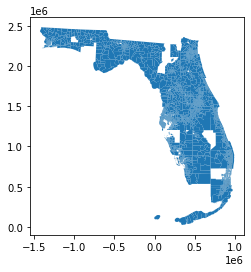

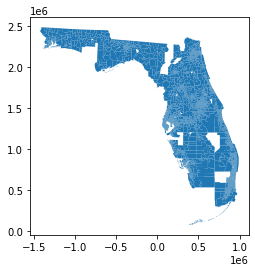

In [135]:
source_geoms.plot()
vest_geoms.plot()

In [136]:
print(source_geoms["geometry_x"].is_valid.value_counts())
print(vest_geoms["geometry_y"].is_valid.value_counts())

both_valid = source_geoms.is_valid & vest_geoms.is_valid

print(both_valid.value_counts())




True    5746
dtype: int64
True    5746
dtype: int64
True    5746
dtype: int64


In [137]:
gp.overlay(source_geoms,vest_geoms,how="symmetric_difference")

TopologyException: found non-noded intersection between LINESTRING (97594.2 1.43026e+06, 97607 1.43028e+06) and LINESTRING (97607 1.43028e+06, 97603.9 1.43026e+06) at 97606.986201005129 1430280.5402683208 0


TopologicalError: This operation could not be performed. Reason: unknown

In [157]:
file = source_geoms[~vals].difference(vest_geoms[~vals])
file.area.describe()

count    4.323000e+03
mean     2.795731e+07
std      2.870276e+08
min      0.000000e+00
25%      4.381431e+04
50%      1.293848e+05
75%      1.224092e+06
max      1.234451e+10
dtype: float64

In [ ]:
#Show a random difference
test = both[~vals].sample(axis=0,n=1).index[0]
display(both.iloc[test]["geometry_x"])
display(both.iloc[test]["geometry_y"])

#display(gp.overlay(both.iloc[test]["geometry_x"],both.iloc[test]["geometry_y"],how="overlap"))

test = both[~vals].sample(axis=0,n=1).index[0]
display(both.iloc[test]["geometry_x"])
display(both.iloc[test]["geometry_y"])

The first print above includes the Senate Other column, the second does not